<a href="https://colab.research.google.com/github/Gautam-Chauhan/MAPS-Internship-Code/blob/main/object_detection_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Inference with TensorFlow Model Garden

This notebook uses my fine-tuned object detection model to detect trash in images of the streets and drainage canals in the city of Quelimane in Mozambique.

Based on the following tutorial:

https://www.tensorflow.org/tfmodels/vision/object_detection

### PRELIMINARIES

#### Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Install packages

In [2]:
# Uninstall the current numpy version to avoid conflicts
!pip uninstall -y numpy
# Install a numpy version compatible with TensorFlow
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
# Install tf-models-official, ensuring compatibility with the installed numpy and TensorFlow versions
!pip install -U -q "tf-models-official"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.4 MB/s eta 0:00:00


#### Import relevant libraries

In [2]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import cv2

In [3]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.19.0


#### Set paths to files in drive

In [4]:
test_data_input_path = '/content/drive/MyDrive/Object_Detection/Annotations/test.record'
model_dir = '/content/drive/MyDrive/Object_Detection/retinanet_attempt8'
export_dir ='/content/drive/MyDrive/Object_Detection/retinanet_attempt8_export'

#### Load trained model from google drive

In [5]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

### STANDARD INFERENCE

#### Visualise some test images and true bounding boxes

Function to show 'num_of_examples' images from the test dataset, along with their bounding boxes:

In [6]:
category_index={
    1: {
        'id': 1,
        'name': 'Trash'
       },
}
tf_ex_decoder = TfExampleDecoder()

In [7]:
def show_batch(raw_records, num_of_examples):
  plt.figure(figsize=(20, 20))
  use_normalized_coordinates=True
  min_score_thresh = 0.25
  for i, serialized_example in enumerate(raw_records):
    plt.subplot(1, 3, i + 1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)

    image = decoded_tensors['image'].numpy().astype('uint8')
    scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))

    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image,
        decoded_tensors['groundtruth_boxes'].numpy(),
        decoded_tensors['groundtruth_classes'].numpy().astype('int'),
        scores,
        category_index=category_index,
        use_normalized_coordinates=use_normalized_coordinates,
        max_boxes_to_draw=200,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=4)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image-{i+1}')
  plt.show()

Apply the function using the test dataset:

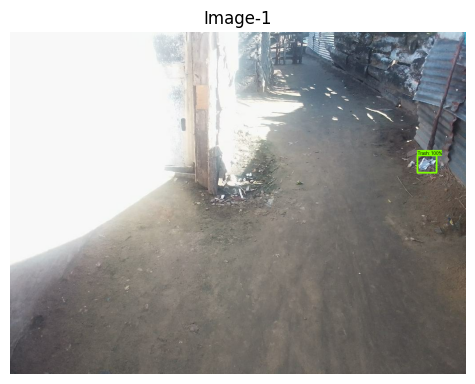

In [25]:
num_of_examples = 1
offset = 1

test_ds = tf.data.TFRecordDataset(test_data_input_path).skip(offset).take(num_of_examples)
show_batch(test_ds, num_of_examples)

#### Visualise some test images and predicted bounding boxes

Function to resize the image so that it has the same size as for training:

In [9]:
def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

Visualise the test images and predicted bounding boxes:

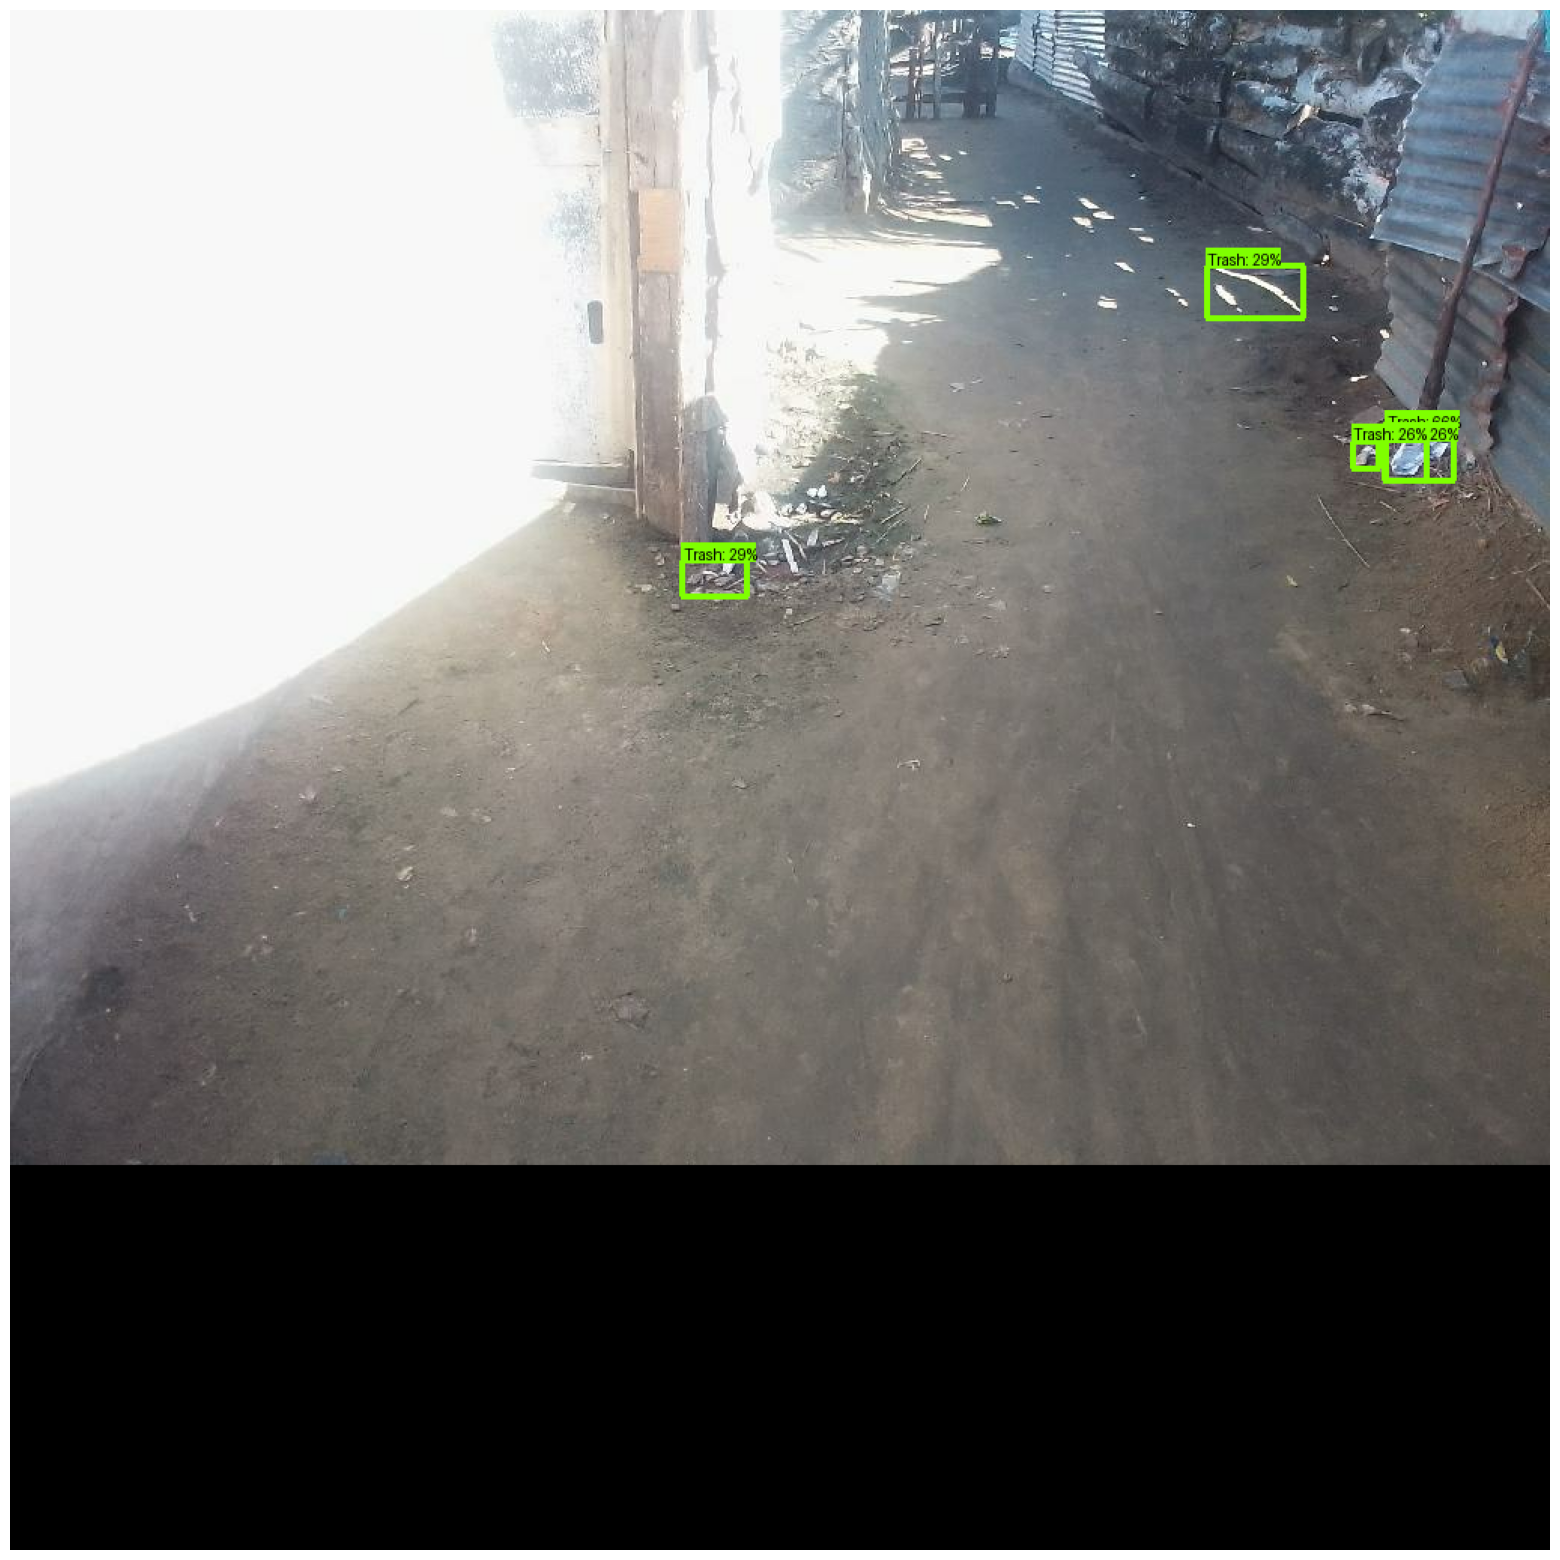

In [26]:
# Rescale images to the size that was used for training
HEIGHT = 1024
WIDTH = 1024
input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.25

for i, serialized_example in enumerate(test_ds):
  plt.subplot(1, 1, i+1)
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  plt.imshow(image_np)
  plt.axis('off')

plt.show()

#### Inference on entire test dataset

In [11]:
full_test = tf.data.TFRecordDataset(test_data_input_path)

Write the images and their groundtruth boxes to a folder in my google drive:

In [12]:
for i, serialized_example in enumerate(full_test):
  decoded_tensors = tf_ex_decoder.decode(serialized_example)

  image = decoded_tensors['image'].numpy().astype('uint8')
  scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))

  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image,
      decoded_tensors['groundtruth_boxes'].numpy(),
      decoded_tensors['groundtruth_classes'].numpy().astype('int'),
      scores,
      category_index=category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.25,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)

  folder_path = '/content/drive/MyDrive/Object_Detection/test_images_true/'
  filename = str(i) + ".jpg"
  cv2.imwrite(folder_path + filename, image)

KeyboardInterrupt: 

Run inference on each example, write the predictions and ground-truth examples to a folder in my google drive, and get the number of bounding boxes.

In [18]:
num_objects = []
true_num_objects = []
for i, serialized_example in enumerate(full_test):
  decoded_tensors = tf_ex_decoder.decode(serialized_example)
  image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, dtype = tf.uint8)
  image_np = image[0].numpy()
  result = model_fn(image)

  # Display bounding boxes for the predictions and write them to a folder
  visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      result['detection_boxes'][0].numpy(),
      result['detection_classes'][0].numpy().astype(int),
      result['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=0.25,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)
  folder_path = '/content/drive/MyDrive/Object_Detection/test_images_predictions_additional/'
  filename = str(i) + ".jpg"

  # Invert colours to format used by OpenCV
  image_np = image_np[:, :, ::-1]
  cv2.imwrite(folder_path + filename, image_np)
  # Get the number of objects that have confidence scores > 0.25 (positive detections)
  detections = [score for score in result['detection_scores'][0].numpy() if score > 0.25]
  # Count the number of positive detections, and add it to the list for the number of objects
  num_objects.append(len(detections))
  # Get the true number of bounding boxes
  true_num_objects.append(len(decoded_tensors['groundtruth_boxes']))

Print the number of bounding boxes and the true number of bounding boxes for each image:

In [14]:
i=0
for item in zip(num_objects, true_num_objects):
  print(str(i)+": "+str(item))
  i+=1

0: (0, 1)
1: (5, 1)
2: (8, 17)
3: (9, 12)
4: (7, 0)
5: (2, 0)
6: (7, 3)
7: (19, 16)
8: (6, 4)
9: (13, 9)
10: (0, 0)
11: (2, 2)
12: (1, 4)
13: (6, 3)
14: (6, 10)
15: (5, 9)
16: (6, 9)
17: (2, 0)
18: (11, 11)
19: (1, 0)
20: (8, 12)
21: (4, 4)
22: (5, 1)
23: (4, 0)
24: (7, 0)
25: (1, 3)
26: (23, 33)
27: (5, 2)
28: (1, 3)
29: (3, 5)
30: (3, 0)
31: (0, 1)
32: (1, 1)
33: (42, 51)
34: (0, 0)
35: (1, 0)
36: (1, 0)
37: (1, 0)
38: (1, 1)
39: (0, 0)
40: (5, 1)
41: (6, 9)
42: (2, 0)
43: (14, 30)
44: (10, 0)
45: (1, 2)
46: (0, 0)
47: (0, 0)
48: (0, 0)
49: (0, 7)
50: (8, 14)
51: (2, 0)
52: (22, 16)
53: (12, 26)
54: (0, 2)
55: (0, 0)
56: (1, 1)
57: (0, 0)
58: (0, 1)
59: (5, 2)
60: (19, 19)
61: (20, 20)
62: (0, 0)
63: (1, 3)
64: (8, 5)
65: (0, 0)
66: (8, 8)
67: (2, 1)
68: (5, 7)
69: (3, 5)
70: (12, 16)
71: (3, 2)
72: (4, 2)
73: (6, 18)
74: (1, 1)
75: (0, 0)
76: (1, 0)
77: (0, 1)
78: (0, 0)
79: (1, 0)
80: (27, 22)
81: (2, 0)
82: (0, 0)
83: (3, 2)
84: (0, 2)
85: (1, 0)
86: (2, 0)
87: (22, 26)
88: (3, 1)

### ATTEMPT AT SAHI

In [ ]:
!pip install sahi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 35.2 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=3c87b1c6fc9064160d1cff7fb1dd6eeb63330a19ec27c94d45bc7b9b456a5e97
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88


Import additional libraries

In [ ]:
from sahi.models.base import DetectionModel
from sahi.prediction import ObjectPrediction
from sahi.predict import get_sliced_prediction
from PIL import Image

Create category mapping:

In [ ]:
category_mapping = {1: "Trash"}

Create a class for a custom SAHI model, which is compatible with our TensorFlow RetinaNet model.

In [ ]:
class TensorFlowDetectionModel(DetectionModel):
    def load_model(self):
        """
        Loads the TensorFlow model. This is already done outside,
        so we just assign it.
        """
        self.model = tf.saved_model.load(export_dir)
        self.infer_function = self.model.signatures['serving_default']

    def perform_inference(self, image: np.ndarray):
        """
        Takes a NumPy image array, performs inference, and returns
        SAHI ObjectPrediction objects.
        """
        # Preprocess image for the model
        #image_rgb = image[:, :, ::-1] # BGR to RGB - only use if loading the
                                       # image with OpenCV. Assumed loading image
                                       # with PIL so don't do this

        input_tensor = tf.convert_to_tensor(image)
        input_tensor = input_tensor[tf.newaxis, ...] # Adds an axis for the
                                                     # inference batch size

        # Run inference
        self._original_predictions = self.infer_function(input_tensor)

    def _create_object_prediction_list_from_original_predictions(
      self,
      shift_amount_list: list = [[0, 0]],
      full_shape_list: list = None,
    ):
      """
      This method converts the raw model outputs to SAHI ObjectPrediction objects
      from which the bounding boes, class labels and confidence scores
      can be extracted
      """

      original_predictions = self._original_predictions

      num_detections = int(original_predictions.pop('num_detections'))
      preds = {key: value[0, :num_detections].numpy()
                      for key, value in original_predictions.items()}
      boxes = preds['detection_boxes']
      scores = preds['detection_scores']
      classes = preds['detection_classes'].astype(np.int64)

      # Get the shift amount for this slice
      shift_x = shift_amount_list[0]
      shift_y = shift_amount_list[1]

      y_scale = 128/1024
      x_scale = 128/1024

      # Get the width and height of the original image
      img_width = full_shape_list[0]
      img_height = full_shape_list[1]

      prediction_list = []
      for i in range(len(boxes)):
          score = scores[i]

          # Filter by confidence threshold
          if score < self.confidence_threshold:
              continue

          # Get bounding box coordinates
          ymin, xmin, ymax, xmax = boxes[i]

          bbox = [
              xmin*x_scale + shift_x,
              ymin*y_scale + shift_y,
              xmax*x_scale + shift_x,
              ymax*y_scale + shift_y
          ]

          prediction_list.append(
              ObjectPrediction(
                  bbox=bbox,
                  category_id=int(classes[i]),
                  score=float(score),
                  category_name=self.category_mapping.get(int(classes[i]))
              )
          )

      self._object_prediction_list_per_image = [prediction_list]

Create an instance of the model and load the model:

In [ ]:
sahi_model = TensorFlowDetectionModel(
    model_path=model_dir, # Can be a placeholder
    category_mapping=category_mapping,
    confidence_threshold=0.25,
    device="cuda:0" # or "cuda:0"
)
sahi_model.load_model() # Manually trigger model loading

Load the image I want to do inference on and rescale it so that it is the same size as I used for training:

In [ ]:
image_record = tf.data.TFRecordDataset(test_data_input_path).skip(0).take(1)
for example in image_record:
  decoded_tensors = tf_ex_decoder.decode(example)
input_image_size = (1024,1024)
image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)

Run the inference on that image:

In [ ]:
# Convert the TensorFlow tensor to a NumPy array
image_np = image.numpy()

# Convert the NumPy array to uint8
image_np = image_np.astype(np.uint8)

# Convert the NumPy array to a Pillow Image
image_pil = Image.fromarray(image_np)

result = get_sliced_prediction(
    image=image_pil,  # Pass the Pillow Image object
    detection_model=sahi_model,
    slice_height=128,
    slice_width=128,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2
)

Performing prediction on 100 slices.


Visualise the results:

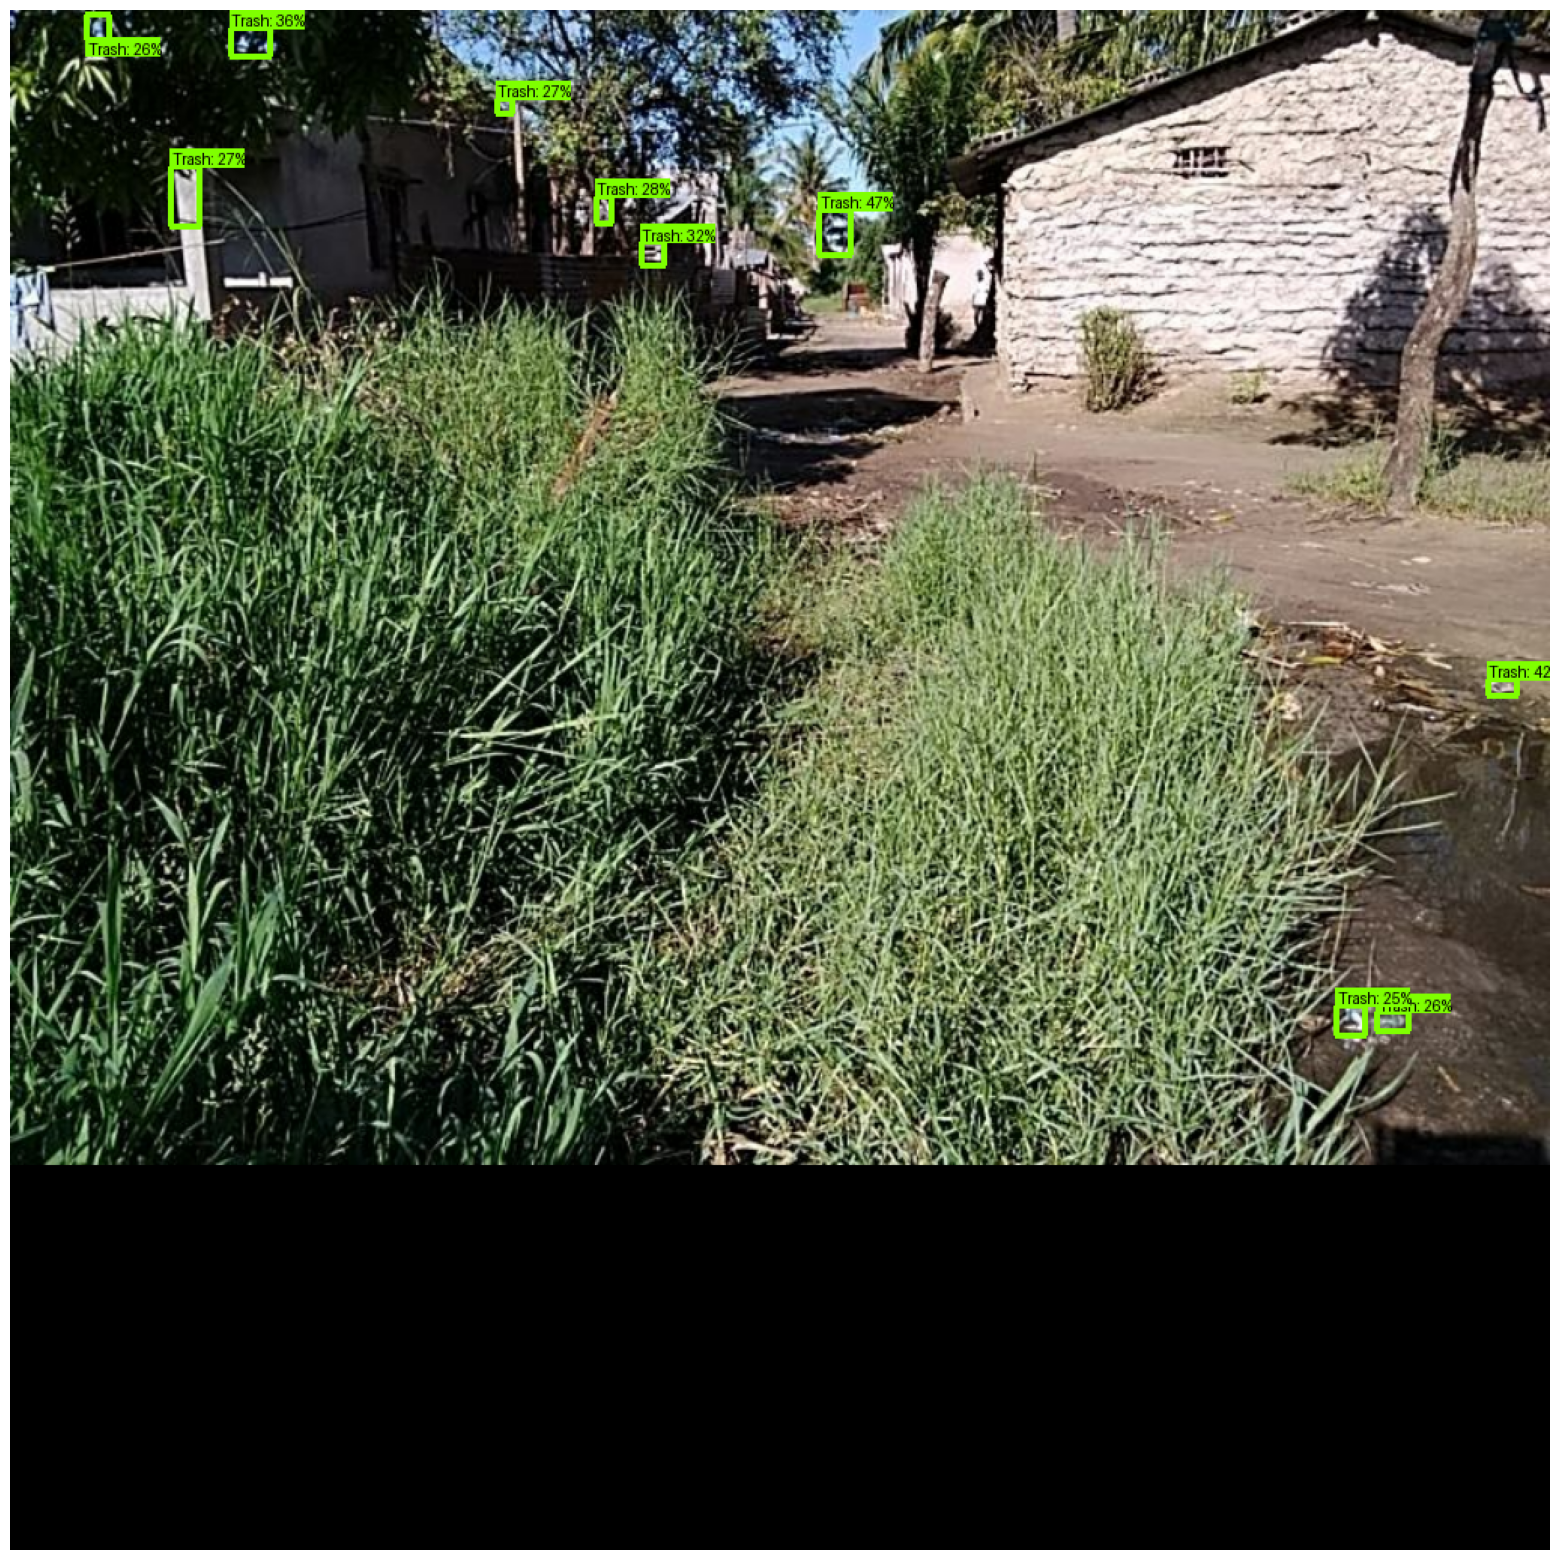

In [ ]:
prediction_list = result.object_prediction_list

bboxes = []
for detection in prediction_list:
  voc_bbox = detection.bbox.to_voc_bbox()
  bbox = [voc_bbox[1], voc_bbox[0], voc_bbox[3], voc_bbox[2]]
  bboxes.append(bbox)

bboxes = np.array(bboxes)
classes = np.array([detection.category.id for detection in prediction_list])
scores = np.array([detection.score.value for detection in prediction_list])

visualization_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      bboxes,
      classes,
      scores,
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=200,
      min_score_thresh=0.25,
      agnostic_mode=False,
      instance_masks=None,
      line_thickness=4)

plt.figure(figsize=(20,20))
plt.imshow(image_np)
plt.axis('off')
plt.show()